In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# EDA

Simply take a look at the dataset

In [35]:
def preprocessing(data):
    data['Arrival_Time'] = (data['Arrival_Time']-data['Arrival_Time'].min())/1e6 # parse in microseconds
    mu = 0.1                                                                     # divide by the capacity
    data['service_time'] = data["CPU"]/mu

    # jobs and their complexity in terms of number of tasks and total service time
    job_data = data.groupby('Job_ID').agg(
        Total_service_time=('service_time', 'sum'),
        Total_CPU = ('CPU','sum'),
        N_tasks=('Task_ID', 'count')
    ).reset_index()
    # remove ghost jobs (with service time = 0)
    ghost_jobs = job_data[job_data.Total_service_time == 0].Job_ID
    data = data[~data['Job_ID'].isin(ghost_jobs.to_list())]

    return data

In [36]:
data = pd.read_csv(r"~\Desktop\uni_ds\NBD\challenge2\Cell_a.csv")
data = preprocessing(data)
data.head()

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,service_time
0,375000667413,0,0.000000,0.041851,0.001169,0.418510
1,375000669289,0,3.386741,0.024968,0.001179,0.249681
2,375000670586,0,5.968153,0.024176,0.001173,0.241756
3,375000670588,0,5.968166,0.019552,0.001163,0.195522
4,375000670590,0,6.016603,0.028044,0.001179,0.280437


## INVESTIGATING ON JOBS

### Are jobs all the same?

First, we see which jobs have more tasks and we look at the sum of the service time of each task of a job.

In [9]:
# jobs and their complexity in terms of number of tasks and total service time
job_data = data.groupby('Job_ID').agg(
    Total_service_time=('service_time', 'sum'),
    Total_CPU = ('CPU','sum'),
    N_tasks=('Task_ID', 'count')
).reset_index()

# Display the resulting DataFrame
print(job_data)

               Job_ID  Total_service_time  Total_CPU  N_tasks
0        375000667413            0.418510   0.041851        1
1        375000669289            0.249681   0.024968        1
2        375000670586            0.241756   0.024176        1
3        375000670588            0.195522   0.019552        1
4        375000670590            0.280437   0.028044        1
...               ...                 ...        ...      ...
1153434  400465207743            0.042477   0.004248        1
1153435  400465207745            0.046768   0.004677        1
1153436  400465219425            0.009003   0.000900        2
1153437  400465256347            0.024586   0.002459        1
1153438  400465256349            0.043488   0.004349        1

[1153439 rows x 4 columns]


In [10]:
job_data.describe()

,Job_ID,Total_service_time,Total_CPU,N_tasks
count,1.153439e+06,1.153439e+06,1.153439e+06,1.153439e+06
mean,3.845261e+11,8.001623e+01,8.001623e+00,2.009274e+00
std,6.384067e+09,1.402571e+04,1.402571e+03,2.139715e+01
min,3.750007e+11,9.536743e-06,9.536743e-07,1.000000e+00
25%,3.810324e+11,2.259541e-01,2.259541e-02,1.000000e+00
50%,3.827375e+11,3.000641e-01,3.000641e-02,1.000000e+00
75%,3.845895e+11,1.046467e+00,1.046467e-01,1.000000e+00
max,4.004653e+11,1.184767e+07,1.184767e+06,2.998000e+03


75% of jobs are simple (with only one task). The most complex job has 3000 tasks. Let's visualize the number of tasks and the total amount of requested service time complex jobs (jobs with more than 1 task).

### Study of number of tasks per job

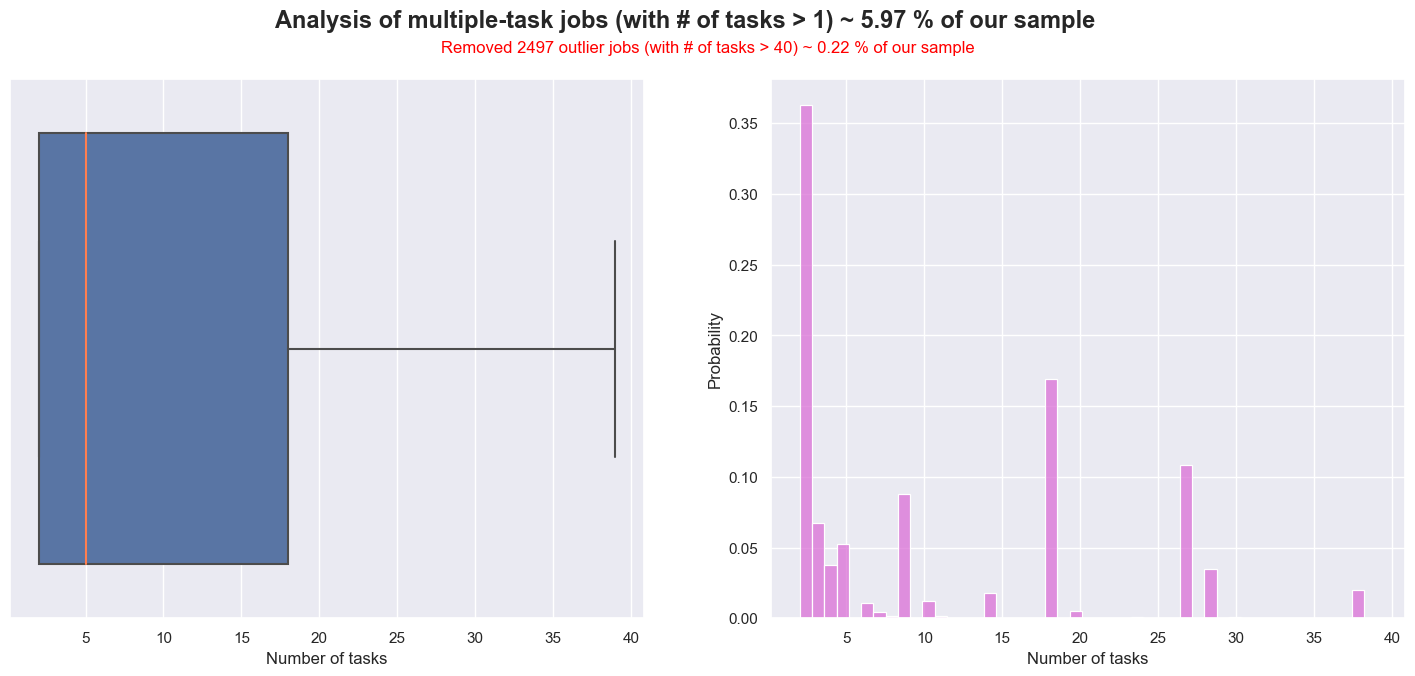

In [34]:
sns.set()
# cut the jobs that ar complex but not outliers
nice_plot_jobs = job_data[(job_data.N_tasks > 1) & (job_data.N_tasks < 40)]
# compute the number of outliers (> than 40 tasks job)
n_outliers = job_data[job_data.N_tasks > 40].shape[0]
# set the grid of plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
# boxplot for the number of tasks distr
sns.boxplot(data = nice_plot_jobs, x="N_tasks", medianprops={"color": "coral"}, orient="h", ax= ax1)
# histogram for the number of tasks distr
sns.histplot(data = nice_plot_jobs, x="N_tasks", color="orchid", ax=ax2, stat="probability")
ax1.set_xlabel("Number of tasks")
ax2.set_xlabel("Number of tasks")
plt.text(x=-21, y=0.40, s=f'Removed {n_outliers} outlier jobs (with # of tasks > 40) ~ {round((job_data[job_data.N_tasks > 40].shape[0]/job_data.shape[0])*100, 2)} % of our sample', fontsize=12, weight='book', color="red")
fig.suptitle(f"Analysis of multiple-task jobs (with # of tasks > 1) ~ {round((job_data[job_data.N_tasks > 1].shape[0]/job_data.shape[0])*100, 2)} % of our sample", fontsize=17, weight="bold")
plt.show()


### Study of Service time per categories of jobs

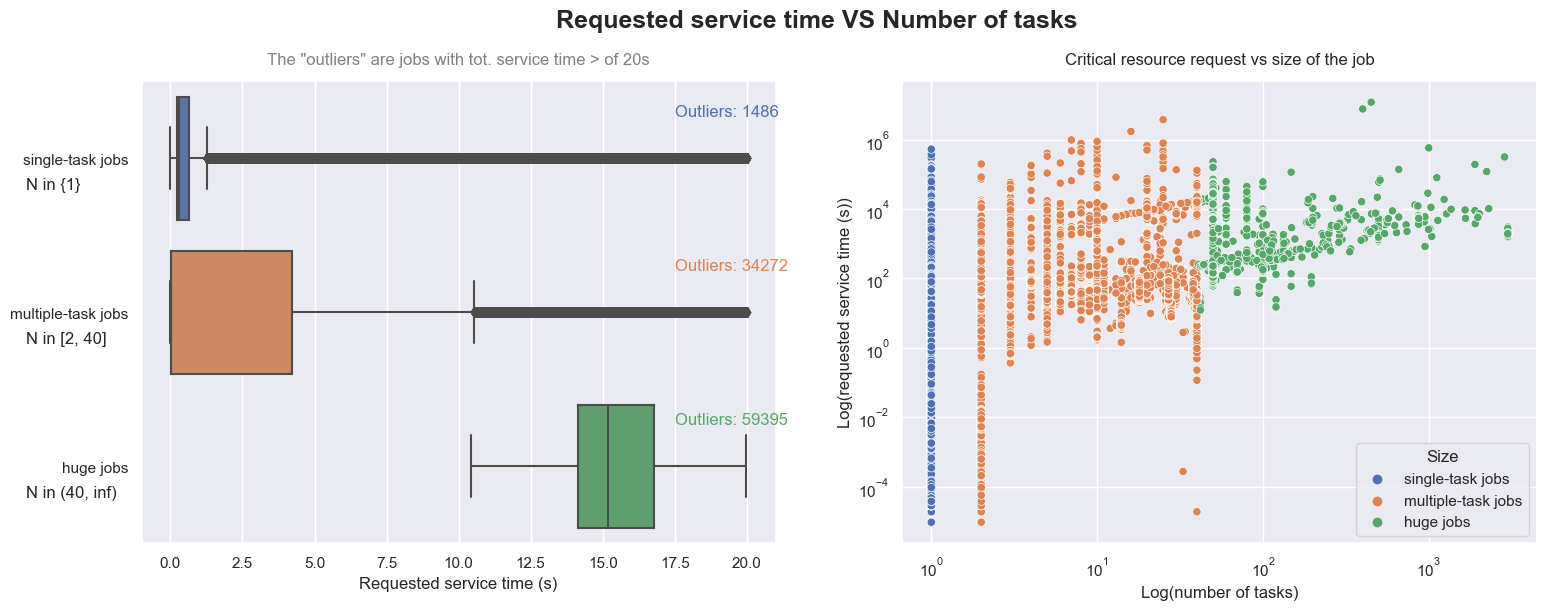

In [22]:
# to avoid side effect
job_data_categorized = job_data.copy()

conditions = [
    (job_data_categorized['N_tasks'] <= 1),
    (job_data_categorized['N_tasks'] > 1) & (job_data_categorized['N_tasks'] <= 40),
    (job_data_categorized['N_tasks'] > 40)
    ]

# create a list of the values we want to assign for each condition
values = ["single-task jobs", "multiple-task jobs", 'huge jobs']

# create a new column and use np.select to assign values to it using our lists as arguments
job_data_categorized['Size'] = np.select(conditions, values)

# calculate the number of outliers for each category
outliers_count = job_data_categorized[job_data_categorized.Total_service_time > 20].groupby("Size").size()

# set the grid of plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
# boxplot for the number of tasks distr
sns.boxplot(data=job_data_categorized[job_data_categorized.Total_service_time < 20], x="Total_service_time", y="Size", ax=ax1)
# scatterplot for the number of tasks vs size of the job in temrs of requested service time
sns.scatterplot(data = job_data_categorized, x="N_tasks", y="Total_service_time", hue = "Size", color="purple", ax=ax2)
# manage labels for plots
ax2.set_xlabel("Log (Number of tasks)")
ax2.set_ylabel("Log (Requested service time [s])")
ax1.set_xlabel("Requested service time [s]")
ax1.set_ylabel(None)
# add titles
ax1.set_title("The \"outliers\" are jobs with tot. service time > of 20s",  fontsize=12, pad=12.0, color="gray")
ax2.set_title("Critical resource request vs size of the job",  fontsize=12, pad=12.0)

vals = {0:"{1}", 1:"[2, 40]",2:"(40, inf)"}
# Add the number of outliers as text to the boxplot
for i, category in enumerate(outliers_count.index):
    ax1.text(17.5, i-0.3, f"Outliers: {outliers_count[category]}", verticalalignment='center', color=sns.color_palette()[i])
    ax1.text(-5, i+0.2, f"N in {vals[i]}", horizontalalignment="left")

ax2.set_xscale('log')
ax2.set_yscale('log')

fig.suptitle('Requested service time VS Number of tasks', fontsize=18, weight="bold", y=1)
plt.show()

### Tasks belonging to the same job arrive at different time? NO, THEY ALL ARRIVE AT THE SAME TIME!

In [ ]:
# job with diference in arrival time of its task
taskXjob_data = data.groupby(['Job_ID']).agg(Base_sys_time=('Arrival_Time', lambda x: x.max() - x.min()), N_tasks=('Task_ID', 'count')).reset_index()
taskXjob_data.describe()

               Job_ID  Base_sys_time  N_tasks
0        375000667413              0        1
775372   383644197581              0        1
775378   383644208167              0        1
775377   383644205308              0        1
775376   383644203576              0        2
...               ...            ...      ...
387693   381718466952              0        1
387694   381718466954              0        1
387695   381718466956              0        1
387696   381718466958              0        1
1163060  400465274601              0        1

[1163061 rows x 3 columns]


,Job_ID,Base_sys_time,N_tasks
count,1.163061e+06,1163061.0,1.163061e+06
mean,3.845497e+11,0.0,2.002589e+00
std,6.401089e+09,0.0,2.130864e+01
min,3.750007e+11,0.0,1.000000e+00
25%,3.810326e+11,0.0,1.000000e+00
50%,3.827403e+11,0.0,1.000000e+00
75%,3.846017e+11,0.0,1.000000e+00
max,4.004653e+11,0.0,2.998000e+03


### Study of arrival time per job

Now, rank the jobs by their arrival time.

In [24]:
# create a df with arrival time per job
job_arrival = data.groupby('Job_ID')['Arrival_Time'].first().reset_index()
# merge the previous datasets and sort the data set by job arrival time
job_data_categorized = job_arrival.merge(job_data_categorized, on='Job_ID').sort_values('Arrival_Time')
job_data_categorized.head()

,Job_ID,Arrival_Time,Total_service_time,Total_CPU,N_tasks,Size
0,375000667413,0.000000,0.418510,0.041851,1,single-task jobs
1,375000669289,3.386741,0.249681,0.024968,1,single-task jobs
2,375000670586,5.968153,0.241756,0.024176,1,single-task jobs
3,375000670588,5.968166,0.195522,0.019552,1,single-task jobs
4,375000670590,6.016603,0.280437,0.028044,1,single-task jobs


Now, I want to have an idea of how jobs arrive at the dispatcher. In particular I am interested to know when huge jobs arrive.

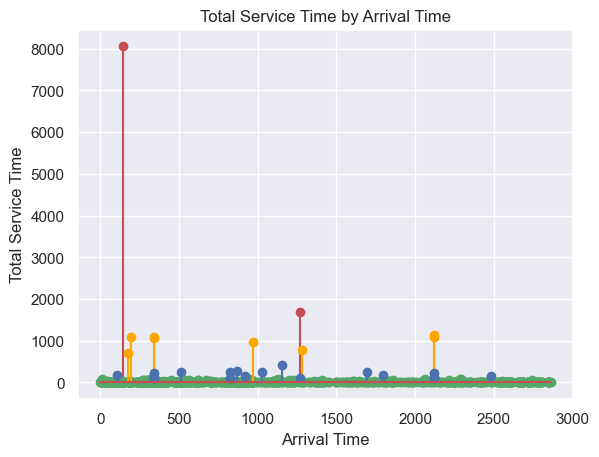

In [29]:
x = job_data_categorized[:1000]['Arrival_Time']
y = job_data_categorized[:1000]['Total_service_time']
sns.set()
# Create a mask for jobs with Total_service_time > 500
mask_red = y >= 1200

# Create a mask for jobs with Total_service_time < 200
mask_green = y < 100

# Create a mask for jobs with Total_service_time between 200 and 1199 (inclusive)
mask_orange = (y >= 500) & (y < 1200)

# Create a mask for all other jobs
mask_blue = ~mask_red & ~mask_green & ~mask_orange

# Plot jobs with Total_service_time > 500 in red
plt.stem(x[mask_red], y[mask_red], linefmt='r-', markerfmt='ro')

# Plot jobs with Total_service_time < 200 in green
plt.stem(x[mask_green], y[mask_green], linefmt='g-', markerfmt='go')

# Plot jobs with Total_service_time between 200 and 1199 in orange
plt.stem(x[mask_orange], y[mask_orange], linefmt='orange', markerfmt='o')

# Plot all other jobs in yellow
plt.stem(x[mask_blue], y[mask_blue], linefmt='b-', markerfmt='bo')

# Set the labels and title
plt.xlabel('Arrival Time')
plt.ylabel('Total Service Time')
plt.title('Total Service Time by Arrival Time')


# Display the plot
plt.show()
